In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!python -m wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv


Saved under housing (9).csv


### EDA

In [3]:
data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


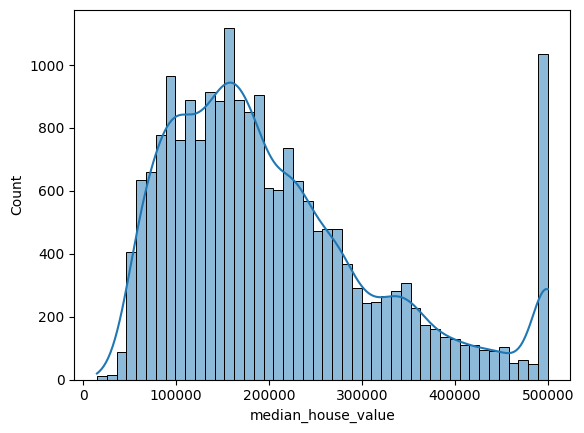

In [4]:
sns.histplot(data['median_house_value'], kde=True);

### Preparing the dataset

In [5]:
filtered_data = data.copy()
filtered_data = filtered_data[filtered_data['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

In [6]:
filtered_data = filtered_data[['latitude',
                                 'longitude',
                                 'housing_median_age',
                                 'total_rooms',
                                 'total_bedrooms',
                                 'population',
                                 'households',
                                 'median_income',
                                 'median_house_value']]

In [7]:
filtered_data.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


### Question 1

In [8]:
filtered_data.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

### Question 2

In [9]:
filtered_data['population'].median()

1195.0

### Prepare and split the dataset

In [10]:
np.random.seed(42)

In [11]:
def split_dataset(data):
    n = len(data)

    n_train = int(n * 0.6)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    
    idx = np.arange(n)
    np.random.shuffle(idx)
    
    data_train = data.iloc[idx[n_train:]]
    data_val = data.iloc[idx[n_train:n_train+n_val]]
    data_test = data.iloc[idx[n_train+n_val:]]
    
    return data_train, data_val, data_test

In [12]:
data_train, data_val, data_test = split_dataset(filtered_data)

In [13]:
len(data_train), len(data_val), len(data_test)

(6275, 3137, 3138)

In [14]:
data_train.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
5498,34.00,-118.41,18.0,1307.0,441.0,884.0,456.0,2.9338,276300.0
9235,37.02,-120.09,9.0,1608.0,297.0,1057.0,295.0,3.7143,81600.0
11104,33.84,-117.88,34.0,1410.0,214.0,837.0,240.0,6.1168,213900.0
7428,33.95,-118.21,32.0,1116.0,328.0,1265.0,302.0,2.2950,155200.0
19928,36.32,-119.32,29.0,2409.0,436.0,1142.0,440.0,3.6895,87700.0


In [15]:
y_train = np.log1p(data_train['median_house_value'].values)
y_val = np.log1p(data_val['median_house_value'].values)
y_test = np.log1p(data_test['median_house_value'].values)

In [16]:
del data_train['median_house_value']
del data_val['median_house_value']
del data_test['median_house_value']

### Question 3

In [17]:
def train_LR(X, y, r=None):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    if r:
        XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [18]:
def rmse(y, y_pred):
    err = y - y_pred 
    se = err ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [19]:
X_train = data_train.fillna(0).values
X_val = data_val.fillna(0).values

w0, w = train_LR(X_train, y_train)
y_pred = w0 + X_val.dot(w)

round(rmse(y_val, y_pred), 2)

0.34

In [20]:
X_train = data_train.fillna(data_train.mean()).values
X_val = data_val.fillna(data_train.mean()).values

w0, w = train_LR(X_train, y_train)
y_pred = w0 + X_val.dot(w)

round(rmse(y_val, y_pred), 2)

0.34

### Question 4

In [21]:
R = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

for r in R:
    X_train = data_train.fillna(0).values
    X_val = data_val.fillna(0).values

    w0, w = train_LR(X_train, y_train, r=r)
    y_pred = w0 + X_val.dot(w)

    print(f'r={r}, rmse={round(rmse(y_val, y_pred), 2)}')

r=0, rmse=0.34
r=1e-06, rmse=0.34
r=0.0001, rmse=0.34
r=0.001, rmse=0.34
r=0.01, rmse=0.34
r=0.1, rmse=0.34
r=1, rmse=0.35
r=5, rmse=0.35
r=10, rmse=0.35


### Question 5

In [22]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []
for seed in seeds:
    np.random.seed(seed)
    data_train, data_val, data_test = split_dataset(filtered_data)
    
    y_train = np.log1p(data_train['median_house_value'].values)
    y_val = np.log1p(data_val['median_house_value'].values)
    y_test = np.log1p(data_test['median_house_value'].values)
    
    del data_train['median_house_value']
    del data_val['median_house_value']
    del data_test['median_house_value']
    
    X_train = data_train.fillna(0).values
    X_val = data_val.fillna(0).values

    w0, w = train_LR(X_train, y_train)
    y_pred = w0 + X_val.dot(w)

    scores.append(rmse(y_val, y_pred))

In [23]:
std = np.std(scores)
round(std, 3)

0.005

### Question 6

In [24]:
np.random.seed(9)
data_train, data_val, data_test = split_dataset(filtered_data)

y_train = np.log1p(data_train['median_house_value'].values)
y_val = np.log1p(data_val['median_house_value'].values)
y_test = np.log1p(data_test['median_house_value'].values)

del data_train['median_house_value']
del data_val['median_house_value']
del data_test['median_house_value']

In [25]:
X_train = pd.concat([data_train, data_val])
y_train = np.concatenate((y_train, y_val), axis=0)

In [26]:
X_train = X_train.fillna(0).values
X_test = data_test.fillna(0).values

In [27]:
w0, w = train_LR(X_train, y_train, r=0.001)
y_pred = w0 + X_test.dot(w)

round(rmse(y_test, y_pred), 2)

0.33